In [94]:
import genomeview
import pyBigWig
import subprocess, os, glob
import pandas as pd
import numpy as np
from IPython.display import display, HTML

def create_pwm(cov_path):
    """returns PWM"""
    rev_comp = {'a':'T', 't':'A', 'c':'G', 'g':'C'}
    qual_dict = {}
    for idx, x in enumerate(range(300)): # ASCII -33 (PHRED)
        qual_dict[chr(x)] = idx-33

    chrom_list = []
    pos_list = []
    ref_list = []
    baseq_list = []
    mapq_list = []
    A_list = []
    T_list = []
    G_list = []
    C_list = []
    cbase_list = []

    for line in open(cov_path):
        ID,pos,ref,num_reads,bases,base_qual,map_qual = line.split()
        chrom_list = chrom_list + [ID]
        pos_list = pos_list + [pos]
        ref_list = ref_list + [ref]
        baseq_list = baseq_list + [int(np.median([qual_dict[x] for x in base_qual]))]
        mapq_list = mapq_list + [int(np.median([qual_dict[x] for x in map_qual]))]

        if int(num_reads) == 0: # at least 1 read coverage
            A_list = A_list + [0]
            T_list = T_list + [0]
            G_list = G_list + [0]
            C_list = C_list + [0]
            cbase_list = cbase_list + [ref]
        else:
            counts = {'A':0, 'C':0, 'G':0, 'T':0}
            for c in bases:
                if c in {'.', ','}:
                    counts[ref] += 1
                elif c in {'A', 'C', 'G', 'T'}:
                    counts[c] += 1
                elif c in {'a', 'c', 'g', 't'}:
                    counts[rev_comp[c]] += 1
            if sum(counts.values()) == 0: # at least 1 base detected
                A_list = A_list + [0]
                T_list = T_list + [0]
                G_list = G_list + [0]
                C_list = C_list + [0]
                cbase_list = cbase_list + [ref]
            else:
                A_list = A_list + [counts['A']]
                T_list = T_list + [counts['T']]
                G_list = G_list + [counts['G']]
                C_list = C_list + [counts['C']]
                cbase_list = cbase_list + [max(counts, key=lambda key: counts[key])]

    pwm = pd.DataFrame({'chrom':chrom_list,
                        'pos':pos_list,
                        'ref':ref_list,
                        'baseq':baseq_list,
                        'mapq':mapq_list,
                        'chrom':chrom_list,
                        'A':A_list,
                        'T':T_list,
                        'G':G_list,
                        'C':C_list,
                        'cbase':cbase_list
                       })
    pwm['match'] = [x==y for x,y in zip(pwm['ref'], pwm['cbase'])]
    
    return pwm

In [109]:
# output_dir = '/mnt/ibm_lg/daniel_le/data/botryllus/results/'
output_dir = '/mnt/ibm_lg/daniel_le/data/botryllus/coverage/bwa_coverage/'
completed_targets = glob.glob(f'{output_dir}*.bw')
completed_targets = [x.split('/sample_')[-1].split('_bs1.bw')[0] for x in completed_targets]
completed_targets

['25',
 '67',
 '58',
 '37',
 '21',
 '79',
 '57',
 '15',
 '5',
 '65',
 '88',
 '82',
 '17',
 '24',
 '14',
 '52',
 '45',
 '42',
 '40',
 '16',
 '60',
 '11',
 '38',
 '53',
 '10',
 '93',
 '3',
 '27',
 '66',
 '96',
 '87',
 '73',
 '84',
 '85',
 '89',
 '22',
 '49',
 '50',
 '6',
 '71',
 '69',
 '33',
 '30',
 '26',
 '48',
 '51',
 '76',
 '13',
 '75',
 '61',
 '54',
 '68',
 '86',
 '80',
 '28',
 '78',
 '32',
 '91',
 '56',
 '9',
 '81',
 '43',
 '64',
 '29',
 '55',
 '8',
 '39',
 '44',
 '90',
 '95',
 '77',
 '2',
 '72',
 '59',
 '34',
 '47',
 '36',
 '62',
 '7',
 '0',
 '92',
 '1',
 '4',
 '83',
 '12',
 '31',
 '19',
 '94',
 '41',
 '18',
 '20',
 '63',
 '97',
 '35',
 '74',
 '23',
 '46']

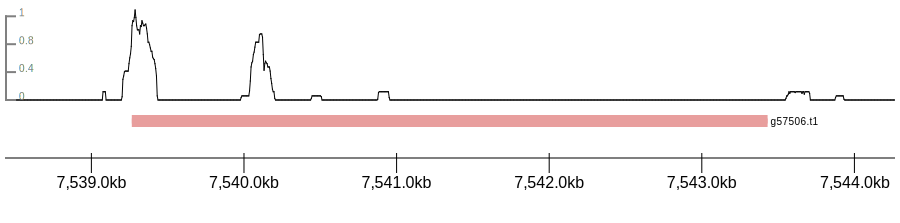

In [118]:
sample_index = 23

fasta_path = '/mnt/ibm_lg/daniel_le/data/botryllus/genome/botznik-chr.fa'
genebed_path = '/mnt/ibm_lg/daniel_le/data/botryllus/genome/botznik-chr-all.bed'
#STAR
# bam_path = f'{output_dir}sample_{sample_index}_Aligned.sortedByCoord.out.bam'
# bw_path = f'{output_dir}sample_{sample_index}_Aligned.sortedByCoord.out.bam.bw'
#BWA
bw_path = f'{output_dir}sample_{sample_index}_bs1.bw'
dataset_paths = [
#                  bam_path,
                 bw_path,
                 genebed_path,
                ]

# BHF = chr9:7538434..7544266
chrom = "chr9"
start = 7538434
end =   7544266

# create pileup
bw_path = f'/mnt/ibm_lg/daniel_le/data/botryllus/results/sample_{sample_index}_Aligned.sortedByCoord.out.bam.bw'
cov_dir = '/mnt/ibm_lg/daniel_le/data/botryllus/coverage/'
cov_path = f'{cov_dir}sample_{sample_index}_{chrom}:{start}-{end}.pileup'
    
if not os.path.exists(bw_path):
    subprocess.call(['samtools',
                     'mpileup',
                     '-s',
                     '-f',
                     fasta_path,
                     '-r',
                     f'{chrom}:{start}-{end}',
                     bam_path,
                     '-o',
                     cov_path
                    ])

doc = genomeview.visualize_data(dataset_paths, chrom, start, end, fasta_path)
doc


In [119]:
pwm = create_pwm(cov_path)
pwm[pwm['match'] == False]

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/ibm_lg/daniel_le/data/botryllus/coverage/sample_23_chr9:7538434-7544266.pileup'